# Data Reduction and Transformation


In [325]:
import transformation_utils as utils
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler

In [326]:
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [327]:
df = pd.read_csv("../data/integrated.csv")
target = "playoff"

## Eliminating Redundant Features


In [328]:
df.drop(
    [
        "round",
        "series",
        "tmIDWinner",
        "tmIDLoser",
        "W_series",
        "L_series",
        "franchID",
        "name",
        "bioID",
        "coachID",
    ],
    axis=1,
    inplace=True,
)

## Feature Engineering


In [329]:
new_df = pd.DataFrame()
for year in df["year"].unique():
    for team in df["tmID"].unique():
        small_df = df[(df["tmID"] == team) & (df["year"] == year)]
        if small_df.empty:
            continue

        d = pd.DataFrame([small_df.iloc[0]])
        d.fillna(0, inplace=True)
        d["award_player"] = small_df["award_player"].count()
        d["award_coach"] = d["award_coach"].apply(lambda i: 1 if i != 0 else 0)
        d["CBE_Sum"] = small_df["CBE_Sum"].mean()
        d["height"] = small_df["height"].mean()
        d["weight"] = small_df["weight"].mean()
        d["playersAge"] = (2000 + df["year"]) - utils.get_overall_age(
            small_df["birthDate"]
        )
        d.drop("playerID", axis=1, inplace=True)
        d.drop("birthDate", axis=1, inplace=True)

        new_df = pd.concat([new_df, d])

df = new_df.sort_values(by=["year", "tmID"])
df.drop(["tmID"], axis=1, inplace=True)

In [330]:
mapping = {"L": 1, "W": 1, "N": 0}

df["semis"] = df["semis"].map(mapping)
df["finals"] = df["finals"].map(mapping)
df["firstRound"] = df["firstRound"].map(mapping)

df["roundsPlayed"] = df["semis"] + df["finals"] + df["firstRound"]
df.drop(["semis", "finals", "firstRound"], axis=1, inplace=True)

## Manual Feature Selection


In [331]:
utils.print_columns(df)
df.drop(
    [
        "attend",
        "arena",
        "awayL",
        "confL",
        "homeL",
        "d_oreb",
        "d_dreb",
        "o_oreb",
        "o_dreb",
        "L_team_post",
        "lost_team",
    ],
    axis=1,
    inplace=True,
)

[ year, W_team_post, L_team_post, confID, rank, playoff, o_fgm, o_fga, o_ftm, o_fta, o_3pm, o_3pa, o_oreb, o_dreb, o_reb, o_asts, o_pf, o_stl, o_to, o_blk, o_pts, d_fgm, d_fga, d_ftm, d_fta, d_3pm, d_3pa, d_oreb, d_dreb, d_reb, d_asts, d_pf, d_stl, d_to, d_blk, d_pts, won_team, lost_team, GP, homeW, homeL, awayW, awayL, confW, confL, min, attend, arena, stint, won_coach, lost_coach, post_wins, post_losses, CBE_Sum, height, weight, award_player, award_coach, playersAge, roundsPlayed ]


In [332]:
# Assuming your DataFrame is named 'df'
# Define weights for each statistic
w1, w2, w3, w4 = 1, 0.8, 0.5, 0.7  # Adjust these weights based on your preferences

# Calculate ATR for each row
df["ATR"] = (
    (w1 * (df["o_pts"]) - df["d_pts"])
    + (w2 * (df["o_reb"] - df["d_reb"]))
    + (w3 * (df["o_asts"] - df["d_asts"]))
    + (w4 * (df["o_fgm"] - df["d_fgm"]))
)

df.drop(
    ["o_pts", "o_reb", "o_asts", "o_fgm", "d_pts", "d_reb", "d_asts", "d_fgm"],
    axis=1,
    inplace=True,
)

## Feature Encoding


In [333]:
le = LabelEncoder()
df[target] = le.fit_transform(df[target])
df["confID"] = le.fit_transform(df["confID"])

key_cols = ["confID", "year", "playoff"]
numerical_cols = [col for col in df.columns if col not in key_cols]

## Feature Scaling


In [334]:
scaler = RobustScaler()
normalizer = MinMaxScaler()

df[numerical_cols] = scaler.fit_transform(df.drop(key_cols, axis=1))
df[numerical_cols] = normalizer.fit_transform(df.drop(key_cols, axis=1))
df.head()

,year,W_team_post,confID,rank,playoff,o_fga,o_ftm,o_fta,o_3pm,o_3pa,...,post_wins,post_losses,CBE_Sum,height,weight,award_player,award_coach,playersAge,roundsPlayed,ATR
119,2,0.000000,0,1.000000,1,0.218792,0.292537,0.261501,0.312217,0.303183,...,0.000000,0.0,0.316584,0.262097,0.330043,0.000000,0.0,0.440079,0.000000,0.255930
206,2,0.428571,0,0.142857,1,0.118121,0.277612,0.244552,0.357466,0.338358,...,0.428571,0.6,0.452861,0.395161,0.625732,0.000000,0.0,0.261297,0.666667,0.651684
372,2,0.000000,0,0.571429,0,0.322148,0.555224,0.556901,0.063348,0.113903,...,0.000000,0.0,0.147339,0.383065,0.337606,0.000000,0.0,0.385069,0.000000,0.450269
202,2,0.857143,1,0.142857,1,0.206711,0.561194,0.399516,0.497738,0.479062,...,0.857143,0.0,0.110306,0.410557,0.476134,0.333333,0.0,0.706376,1.000000,1.000000
258,2,0.000000,0,0.857143,0,0.131544,0.283582,0.242131,0.592760,0.529313,...,0.000000,0.0,0.322328,0.415633,0.436789,0.000000,0.0,0.329001,0.000000,0.431374


## Grid Search for SelectKBest and PCA


In [335]:
random_state = 42

Simple version of Grid Search for SelectKBest and PCA where the classifier is already defined.


In [336]:
# from sklearn.neural_network import MLPClassifier
# clf = MLPClassifier(batch_size=8, max_iter=10000, random_state=random_state)
# results = utils.grid_search_features(df, key_cols, target, clf, 10)
# utils.display_num_features_results(results)

In this version, we run the Grid Search for several classifiers and compare the results.

In [337]:
# classifiers = [
#     ("DTC", DecisionTreeClassifier(random_state=random_state)),
#     ("MLP", MLPClassifier(batch_size=8, max_iter=10000, random_state=random_state)),
#     ("SVM", SVC(probability=True, random_state=random_state)),
#     ("RFC", RandomForestClassifier(random_state=random_state)),
#     ("KNN", KNeighborsClassifier(n_neighbors=5, weights="distance")),
#     ("Bagging", BaggingClassifier(random_state=random_state)),
#     ("AdaBoost", AdaBoostClassifier(random_state=random_state)),
#     ("GradientBoosting", GradientBoostingClassifier(random_state=random_state)),
#     ("ExtraTrees", ExtraTreesClassifier(random_state=random_state)),
#     ("LogisticRegression", LogisticRegression(random_state=random_state)),
#     ("NB", GaussianNB()),
# ]
#
# results = []
# for classifier in classifiers:
#     grid = utils.grid_search_features(df, key_cols, target, classifier[1], 10)
#     results.append((classifier[0], grid[0]))
#
# print(results)

## Feature Selection


In [338]:
n_features = 17
n_components = 7

df_copy = df.copy(
    deep=True
)  # Copy of the dataframe before we do feature selection and aggregation

In [339]:
initial = df.columns
df = utils.select_features(df, target, key_cols, n_features)

print("Removed: ", set(initial) - set(df.columns))

Removed:  {'award_coach', 'o_to', 'o_fta', 'd_3pa', 'd_blk', 'weight', 'o_blk', 'd_pf', 'o_3pm', 'o_pf', 'o_3pa', 'height', 'GP', 'min', 'd_fga', 'o_stl', 'd_fta', 'd_3pm', 'd_stl', 'd_ftm', 'd_to', 'o_ftm'}


## Feature Aggregation


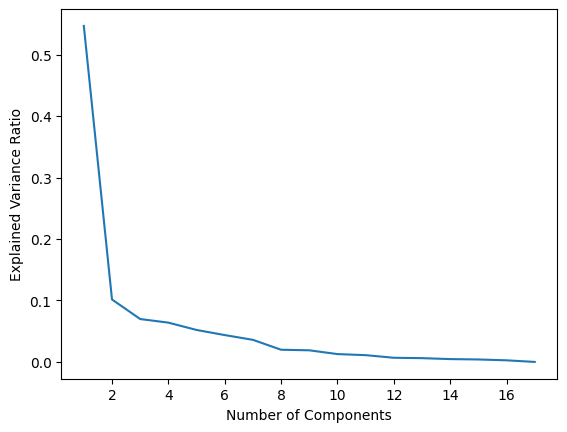

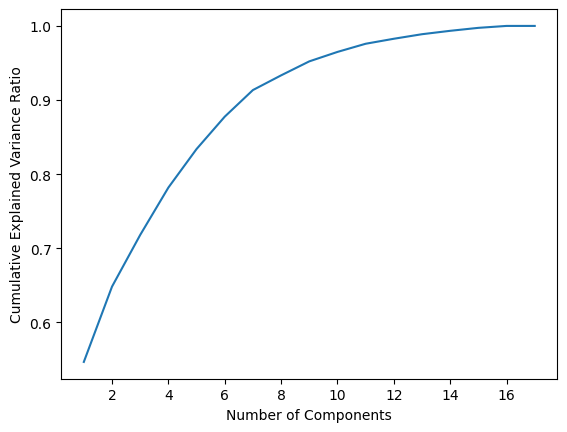

In [340]:
utils.plot_pca(df.drop(key_cols, axis=1))

In [341]:
old_df = df.copy()
df = utils.feature_aggregation_pca(df, n_components, key_cols)
utils.print_columns(df)

[ PC1, PC2, PC3, PC4, PC5, PC6, PC7, confID, year, playoff ]


## Checking for Correlation


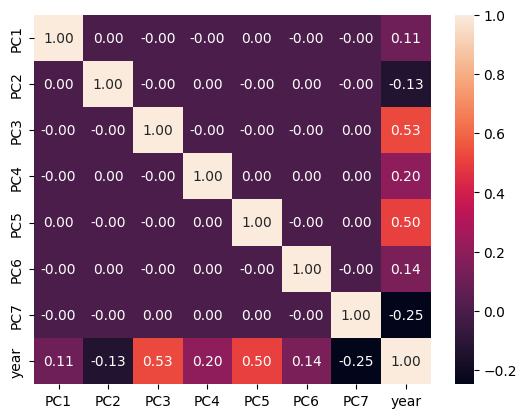

<Figure size 14400x14400 with 0 Axes>

In [342]:
corr_excluded_cols = key_cols[:]
corr_excluded_cols.remove("year")
utils.plot_correlation(df.drop(corr_excluded_cols, axis=1))

## Checking for null values


In [343]:
print("Number of null values: ", df.isnull().sum().sum())

Number of null values:  0


## Creating new dataframes for each model


In [344]:
import os, shutil, copy

# (Model, (n_features, n_components, accuracy, f1_score, auc))
models = [
    ("DTC", (14, 2, 84.61999999999999, 87.5, 93.75)),
    ("MLP", (14, 4, 100.0, 100.0, 100.0)),
    ("RFC", (15, 4, 84.61999999999999, 87.5, 90.0)),
    ("Bagging", (20, 14, 84.61999999999999, 87.5, 90.0)),
    ("AdaBoost", (24, 4, 100.0, 100.0, 92.5)),
    ("GradientBoosting", (16, 3, 100.0, 100.0, 90.0)),
    ("ExtraTrees", (35, 10, 84.61999999999999, 87.5, 86.25)),
    ("LogisticRegression", (15, 4, 84.61999999999999, 87.5, 90.0)),
    ("NB", (17, 7, 100.0, 100.0, 100.0)),
]
if os.path.exists("../data/transformed"):
    shutil.rmtree("../data/transformed")
os.mkdir("../data/transformed")
for model in models:
    df_copy1 = df_copy.copy(deep=True)
    df_copy1 = utils.select_features(df_copy1, target, key_cols, model[1][0])
    df_copy1 = utils.feature_aggregation_pca(df_copy1, model[1][1], key_cols)
    df_copy1.to_csv(f"../data/transformed/{model[0]}.csv", index=False)

# Saving the data


In [345]:
df.to_csv("../data/transformed.csv", index=False)